# https://jaketae.github.io/study/pytorch-rnn/

## Download

In [ ]:
!curl -O https://download.pytorch.org/tutorial/data.zip; unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  11.7M      0 --:--:-- --:--:-- --:--:-- 11.7M
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

## Import Lib

In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import random
from string import ascii_letters

import torch
from torch import nn
import torch.nn.functional as F
from unidecode import unidecode

_ = torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [ ]:
data_dir = "./data/names"

lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}

In [ ]:
lang2label

{'Japanese': tensor([0]),
 'Greek': tensor([1]),
 'Czech': tensor([2]),
 'English': tensor([3]),
 'Chinese': tensor([4]),
 'German': tensor([5]),
 'Italian': tensor([6]),
 'Russian': tensor([7]),
 'Irish': tensor([8]),
 'Dutch': tensor([9]),
 'Polish': tensor([10]),
 'Korean': tensor([11]),
 'Vietnamese': tensor([12]),
 'Scottish': tensor([13]),
 'Portuguese': tensor([14]),
 'Spanish': tensor([15]),
 'French': tensor([16]),
 'Arabic': tensor([17])}

In [ ]:
num_langs = len(lang2label)
print(num_langs)

18


In [ ]:
unidecode("Ślusàrski")

'Slusarski'

In [ ]:
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}
num_letters = len(char2idx)
num_letters

59

In [ ]:
def name2tensor(name):
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, char in enumerate(name):
        tensor[i][0][char2idx[char]] = 1
    return tensor

In [ ]:
name2tensor("abc")

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

## Dataset Creation

In [ ]:
tensor_names = []
target_langs = []

for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file)) as f:
        lang = file.split(".")[0]
        names = [unidecode(line.rstrip()) for line in f]
        for name in names:
            try:
                tensor_names.append(name2tensor(name))
                target_langs.append(lang2label[lang])
            except KeyError:
                pass

In [ ]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    range(len(target_langs)),
    test_size=0.1,
    shuffle=True,
    stratify=target_langs
)

train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

In [ ]:
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 18063
Test: 2007


## Model

### Simple RNN

In [ ]:
class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)

    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.tanh(self.in2hidden(combined))
        output = self.in2output(hidden)
        return output, hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [ ]:
hidden_size = 256
learning_rate = 0.001

model = MyRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)


In [ ]:
num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/2], Step [3000/18063], Loss: 0.0387
Epoch [1/2], Step [6000/18063], Loss: 0.0266
Epoch [1/2], Step [9000/18063], Loss: 2.7217
Epoch [1/2], Step [12000/18063], Loss: 0.0010
Epoch [1/2], Step [15000/18063], Loss: 2.2998
Epoch [1/2], Step [18000/18063], Loss: 0.9647
Epoch [2/2], Step [3000/18063], Loss: 1.0824
Epoch [2/2], Step [6000/18063], Loss: 3.7790
Epoch [2/2], Step [9000/18063], Loss: 6.3841
Epoch [2/2], Step [12000/18063], Loss: 0.0000
Epoch [2/2], Step [15000/18063], Loss: 8.8819
Epoch [2/2], Step [18000/18063], Loss: 0.8639


Evaluate

In [ ]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 67.1649%


Inference

In [ ]:
label2lang = {label.item(): lang for lang, label in lang2label.items()}

def myrnn_predict(name):
    model.eval()
    tensor_name = name2tensor(name)
    with torch.no_grad():
        hidden_state = model.init_hidden()
        for char in tensor_name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
    model.train()
    return label2lang[pred.item()]

In [ ]:
myrnn_predict("Van")

'Chinese'

# RNN Implementation using Pytorch

## Import Lib

In [ ]:
"""
RNN character generator
RNN implementation with Dense layers
There is an RNN layer in pytorch, but in this case we will be using
normal Dense layers to demonstrate the difference between
RNN and Normal feedforward networks.
This is a character level generator, which means it will create character by character
You can input any text file and it will generate characters based on that text
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

## Data preparation

In [ ]:
"""
Data preparation
"""
class TextDataset(Dataset):
    """
    Text Dataset
    Text Dataset Class

    This class is in charge of managing text data as vectors
    Data is saved as vectors (not as text)
    Attributes
    ----------
    seq_length - int: Sequence length
    chars - list(str): List of characters
    char_to_idx - dict: dictionary from character to index
    idx_to_char - dict: dictionary from index to character
    vocab_size - int: Vocabulary size
    data_size - int: total length of the text
    """
    def __init__(self, text_data: str, seq_length: int = 25) -> None:
        """
        Inputs
        ------
        text_data: Full text data as string
        seq_length: sequence length. How many characters per index of the dataset.
        """
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)
        # useful way to fetch characters either by index or char
        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.seq_length = seq_length
        self.X = self.string_to_vector(text_data)

    @property
    def X_string(self) -> str:
        """
        Returns X in string form
        """
        return self.vector_to_string(self.X)

    def __len__(self) -> int:
        """
        We remove the last sequence to avoid conflicts with Y being shifted to the left
        This causes our model to never see the last sequence of text
        which is not a huge deal, but its something to be aware of
        """
        return int(len(self.X) / self.seq_length -1)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        """
        X and Y have the same shape, but Y is shifted left 1 position
        """
        start_idx = index * self.seq_length
        end_idx = (index + 1) * self.seq_length

        X = torch.tensor(self.X[start_idx:end_idx]).float()
        y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()
        return X, y

    def string_to_vector(self, name: str) -> list[int]:
        """
        Converts a string into a 1D vector with values from char_to_idx dictionary
        Inputs
        name: Name as string
        Outputs
        name_tensor: name represented as list of integers (1D vector)
        sample:
        >>> string_to_vector('test')
        [20, 5, 19, 20]
        """
        vector = list()
        for s in name:
            vector.append(self.char_to_idx[s])
        return vector

    def vector_to_string(self, vector: list[int]) -> str:
        """
        Converts a 1D vector into a string with values from idx_to_char dictionary
        Inputs
        vector: 1D vector with values in the range of idx_to_char
        Outputs
        vector_string: Vector converted to string
        sample:
        >>> vector_to_string([20, 5, 19, 20])
        'test'
        """
        vector_string = ""
        for i in vector:
            vector_string += self.idx_to_char[i]
        return vector_string

## Model definition

In [ ]:
"""
Model definition
"""
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)


    def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        return self.h2o(hidden_state), hidden_state


    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)


def generate_text(model: RNN, dataset: TextDataset, prediction_length: int = 100) -> str:
    """
    Generate text up to prediction_length characters
    This function requires the dataset as argument in order to properly
    generate the text and return the output as strings
    """
    model.eval()
    predicted = dataset.vector_to_string([random.randint(0, len(dataset.chars) -1)])
    hidden = model.init_zero_hidden()

    for i in range(prediction_length - 1):
        last_char = torch.Tensor([dataset.char_to_idx[predicted[-1]]])
        X, hidden = last_char.to(device), hidden.to(device)
        out, hidden = model(X, hidden)
        result = torch.multinomial(nn.functional.softmax(out, 1), 1).item()
        #result = out.argmax().item()
        predicted += dataset.idx_to_char[result]

    return predicted



def train(model: RNN, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    Inputs
    ------
    model: RNN model to train
    data: Iterable DataLoader
    epochs: Number of epochs to train the model
    optiimizer: Optimizer to use for each epoch
    loss_fn: Function to calculate loss
    """
    train_losses = {}
    model.to(device)

    model.train()
    print("=> Starting training")
    for epoch in range(epochs):
        epoch_losses = list()
        for X, Y in data:
            # skip batch if it doesnt match with the batch_size
            if X.shape[0] != model.batch_size:
                continue
            hidden = model.init_zero_hidden(batch_size=model.batch_size)

            # send tensors to device
            X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)

            # 2. clear gradients
            model.zero_grad()

            loss = 0
            for c in range(X.shape[1]):
                out, hidden = model(X[:, c].reshape(X.shape[0],1), hidden)
                l = loss_fn(out, Y[:, c].long())
                loss += l

            # 4. Compte gradients gradients
            loss.backward()

            # 5. Adjust learnable parameters
            # clip as well to avoid vanishing and exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), 3)
            optimizer.step()

            epoch_losses.append(loss.detach().item() / X.shape[1])

        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')
        print(generate_text(model, data.dataset))


if __name__ == "__main__":
    data = open('datasets/Dinos/dinos.txt', 'r').read() # use any text file you want to learn
    data = data.lower()

    # Data size variables
    seq_length = 25
    batch_size = 64
    hidden_size = 256

    text_dataset = TextDataset(data, seq_length=seq_length)
    text_dataloader = DataLoader(text_dataset, batch_size)

    # Model
    rnnModel = RNN(1, hidden_size, len(text_dataset.chars)) # 1 because we enter a single number/letter per step.

    # Train variables
    epochs = 1000
    loss = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(rnnModel.parameters(), lr = 0.001)

    train(rnnModel, text_dataloader, epochs, optimizer, loss)


# Full FeedForward + BackPropagation

## Import Lib

In [ ]:
import numpy as np

## RNN class

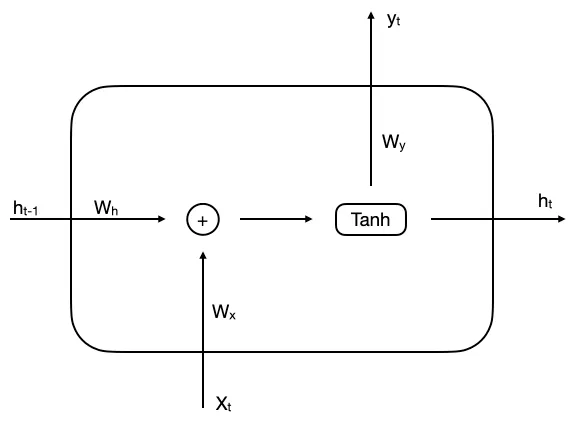

In [ ]:
class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)

    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt

## Dataset

In [ ]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

In [ ]:

def forward(self, sample):
    sample_x, sample_y = self.x[sample], self.y[sample]
    ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
    self.hidden_states = [ht] # collection of hidden states for each sample
    self.inputs = [] # collection of inputs for each sample
    for step in range(len(sample_x)):
        ht, yt = self.cell(sample_x[step],ht)
        self.inputs.append(sample_x[step].reshape(1,1))
        self.hidden_states.append(ht)

    self.error = yt - sample_y
    self.loss = 0.5*self.error**2

In [ ]:
def backward(self):
    n = len(self.inputs)
    dyt = self.error # dL/dyt
    dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
    dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
    dWx = np.zeros(self.Wx.shape)
    dWh = np.zeros(self.Wh.shape)
    # BPTT
    for step in reversed(range(n)):
        temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2)
        dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
        dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

        dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
    dWy = np.clip(dWy, -1, 1)
    dWx = np.clip(dWx, -1, 1)
    dWh = np.clip(dWh, -1, 1)
    self.Wy -= self.lr * dWy
    self.Wx -= self.lr * dWx
    self.Wh -= self.lr * dWh